# Analýza banky

## Příprava dat

In [1]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./historical_sample.csv',sep=';',decimal=',')

In [3]:
df.rename(columns=lambda x: x.lower(), inplace=True)

In [4]:
df

,age,gender,marstat,housing,educ,inc_gr,children,iq,client,rate,cost_type,default_flg
0,18,0,4,2,3,3,1,61.280758,544,0.052944,www,0
1,23,0,1,1,3,3,1,72.224303,665,0.052944,www,0
2,25,0,1,2,3,3,1,86.556911,2692,0.052944,www,0
3,22,0,4,2,3,3,1,70.032964,3227,0.052944,www,1
4,25,0,4,2,3,3,1,81.056197,3491,0.052944,www,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,42,1,2,4,2,2,2,131.379556,9109,0.050000,Broker,0
9996,49,1,2,4,4,4,2,153.353553,9233,0.050000,Broker,0
9997,59,1,2,4,2,2,2,180.000000,9296,0.050000,Broker,0
9998,45,1,2,4,4,4,2,131.212587,9551,0.050000,Broker,0


### Popis dat

| Variable | Character | Description |
| -------- | --------- | ----------- |
| Client | N/A | Identification number of the applicant |
| Age | discrete | Age of applicant |
| Gender | categorical | 0 – Male, 1 – Female |
| MarStat | categorical | Marital Status of the applicant: 1 – divorced, 2 – married, 3 – single, 4 – window/male widow |
| Housing | categorical | Type of applicants’ accommodation: 1 – lives with with parents, 2 – registered at the town hall, 3 – in an own house/apartment, 4 – in a rented house/apartment |
| Educ | categorical | Type of applicants’ education: 1 – elementary, 2 – secondary school, 3 – university, 4 – PhD. |
| Inc_Gr | categorical | Volume of applicants’ income: 1 – receives social security. 2 – receives salary less than 15 000 CZK, 3 – receives salary between 15 000 CZK and 30 000 CZK, 4 – receives salary more than 30 000 CZK |
| Children | discrete | Number of applicant’s children |
| IQ | discrete | Applicant’s IQ |
| Default_flg | discrete | Flag suggesting whether the loan was paid back (=0) or not (default=1) |
| Rate | continuous | Annual interest rate of the applicant’s loan |
| Cost_type | character | Type of distributional channel |


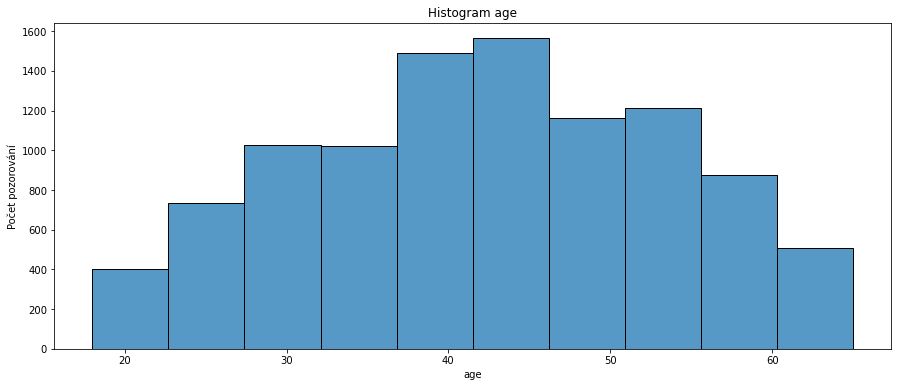

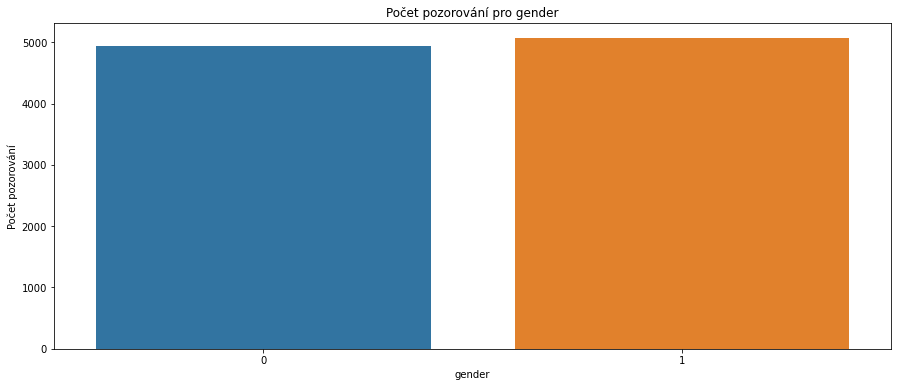

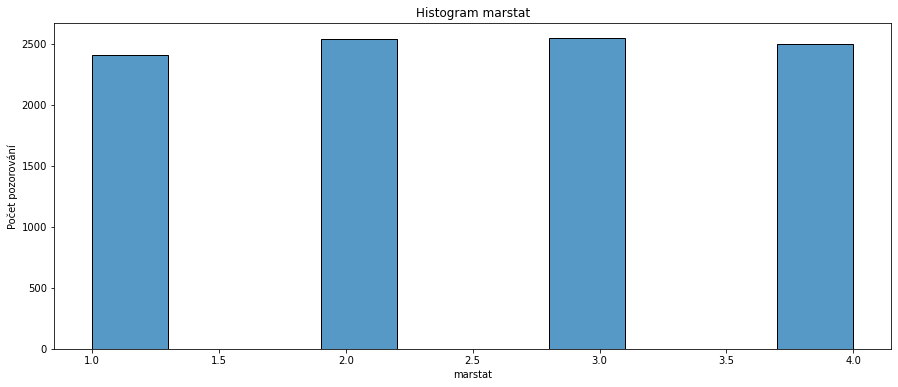

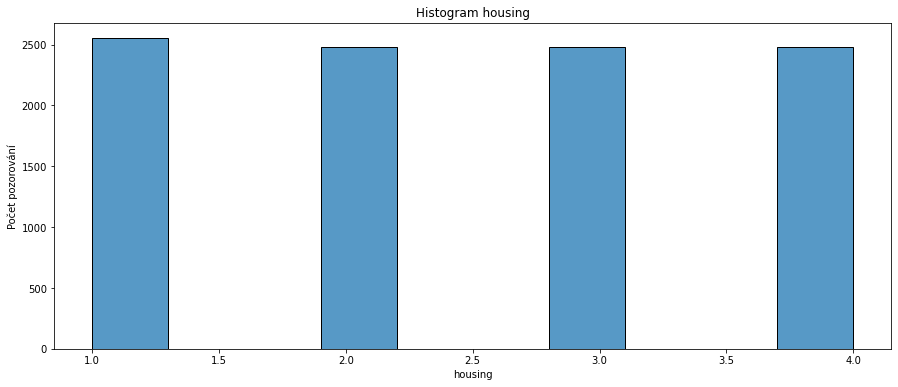

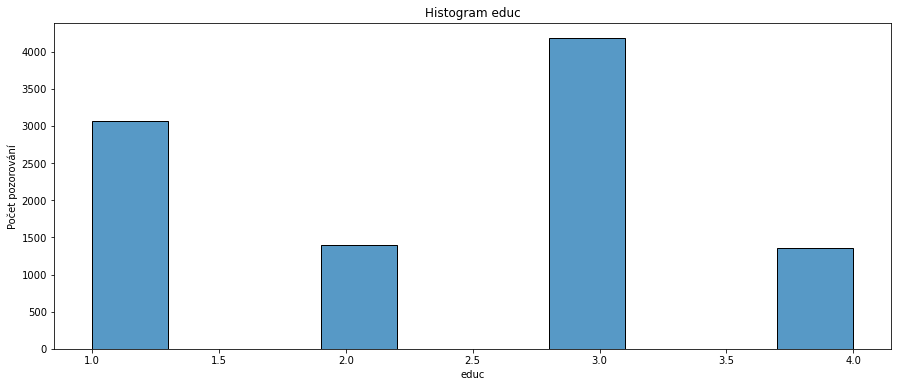

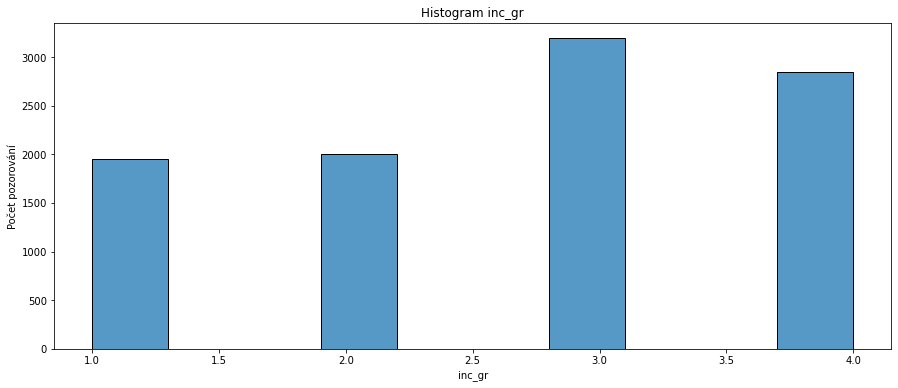

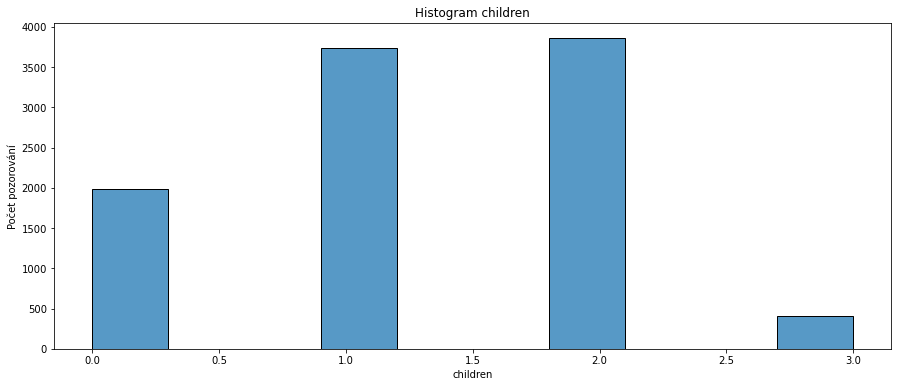

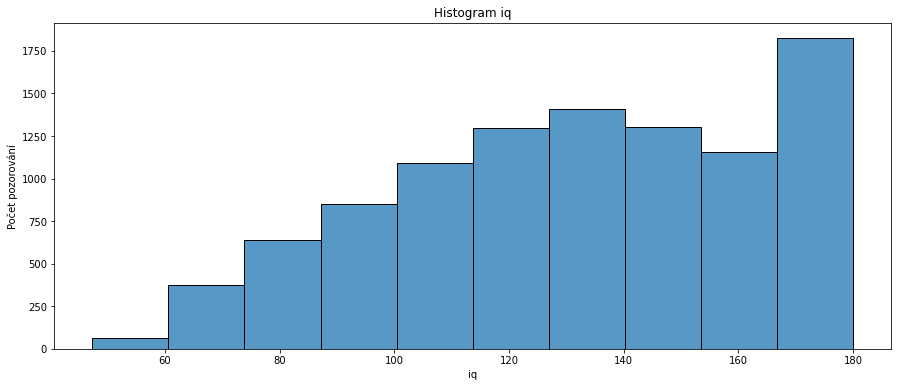

<Figure size 1080x432 with 0 Axes>

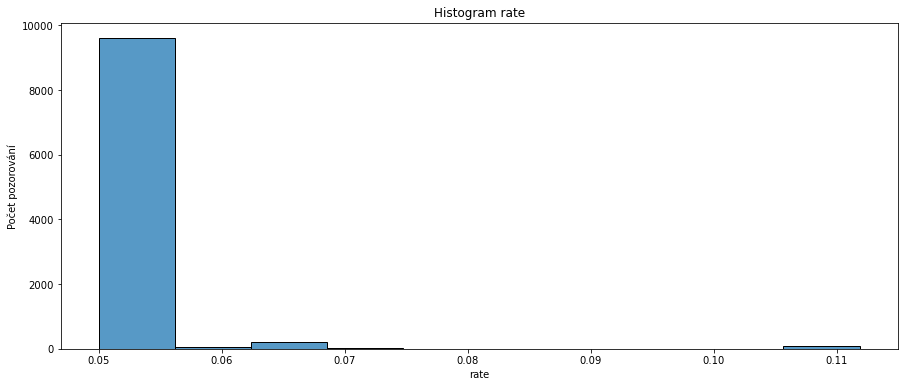

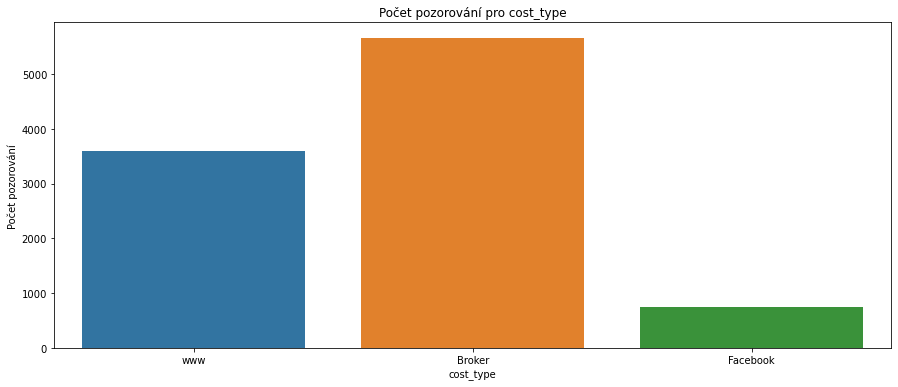

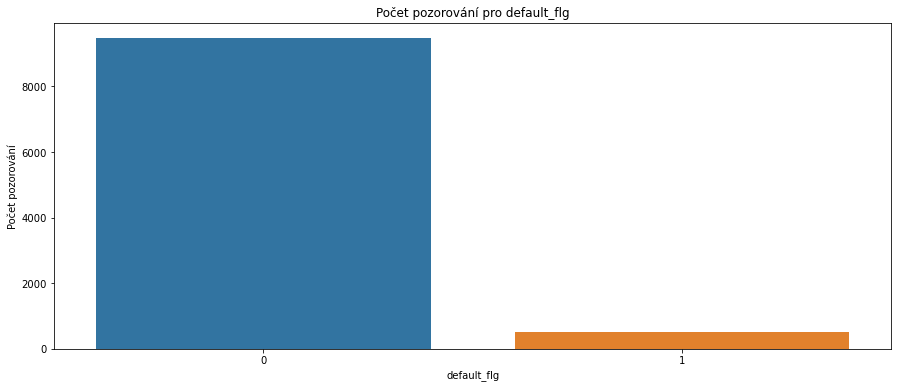

In [536]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in df.columns:
    plt.figure(figsize=(15, 6))
    if column not in ['client']:
        # vykreslení histogramu pro numerické proměnné
        if (df[column].dtype == "int64" or df[column].dtype == "float64") and column not in ['gender', 'default_flg']:
            sns.histplot(data=df, x=column, bins=10)
            plt.xlabel(column)
            plt.ylabel("Počet pozorování")
            plt.title(f"Histogram {column}")
            plt.show()
        # vykreslení sloupcového grafu pro kategoriální proměnné
        else:
            sns.countplot(data=df, x=column)
            plt.xlabel(column)
            plt.ylabel("Počet pozorování")
            plt.title(f"Počet pozorování pro {column}")
            plt.show()

In [537]:
df.isnull().sum()

age            0
gender         0
marstat        0
housing        0
educ           0
inc_gr         0
children       0
iq             0
client         0
rate           0
cost_type      0
default_flg    0
dtype: int64

In [538]:
df['cost_type'].unique()

array(['www', 'Broker', 'Facebook'], dtype=object)

In [539]:
df.dtypes

age              int64
gender           int64
marstat          int64
housing          int64
educ             int64
inc_gr           int64
children         int64
iq             float64
client           int64
rate           float64
cost_type       object
default_flg      int64
dtype: object

<AxesSubplot:>

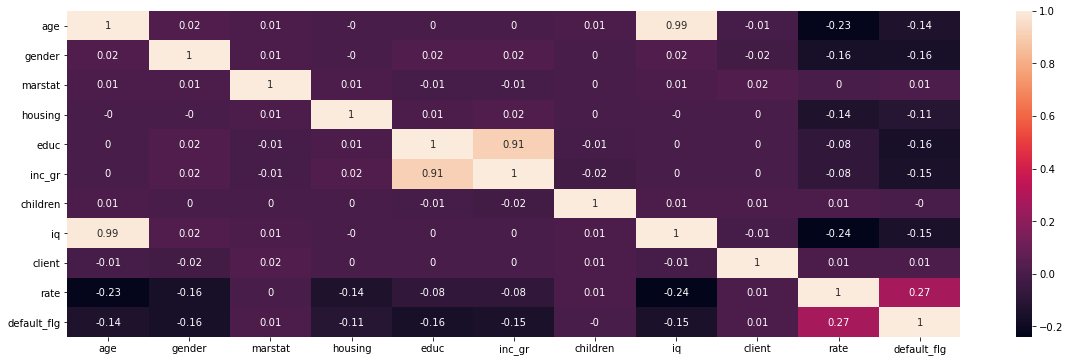

In [540]:
# Korelačn9 matice
plt.figure(figsize=(20, 6))
cor_matrix = round(df.corr(),2)
sns.heatmap(cor_matrix, annot=True)

## Úkol 1


Jelikož sledujeme závislost kategiriální proměnné na numerické (numerických), v prví řadě se pokusíme použít klasickou logistickou regeresi.

In [541]:
# Jelikož pro logistickou regresi potřebujeme binární cílovou proměnnou a my máme 3 kategorie, musíme cílovku binazirovat tím, že vytvoříme dummy proměnné.
cost_type_dummies = pd.get_dummies(df['cost_type'], prefix='cost_type')

df = pd.concat([df, cost_type_dummies], axis=1)

# Odstraníme původní sloupec
# df.drop('cost_type', axis=1, inplace=True)

# VSUVKA - nakonec odstraňovat sloupec nebudu, protože ho pak dále potřebuju pro jiné výpočty.

In [542]:
# Vydefinujeme vysvětlované a vysvětlujicí proměnné
X = df[['iq', 'age']]
y = df[['cost_type_Broker', 'cost_type_Facebook', 'cost_type_www']]

In [543]:
# Dataset rozdělíme na test a train části
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [544]:
# Vytvoříme zvláštní logistický regresní model pro každou dummy proměnnou
from sklearn.linear_model import LogisticRegression

models = []
for column in y_train.columns:
    model = LogisticRegression()
    model.fit(X_train, y_train[column])
    models.append(model)

In [545]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error
from sklearn.metrics import make_scorer,classification_report, f1_score,precision_score,recall_score

y_pred = pd.DataFrame()
for i, model in enumerate(models):
    column_name = y_train.columns[i]
    y_pred[column_name] = model.predict(X_test)
    print(classification_report(y_pred[column_name], y_test[column_name]))
    print('\nAccuracy Score for Logistic regression model: ', accuracy_score(y_pred[column_name], y_test[column_name]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00      1137

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Accuracy Score for Logistic regression model:  1.0
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1998
           1       0.01      0.50      0.02         2

    accuracy                           0.94      2000
   macro avg       0.50      0.72      0.49      2000
weighted avg       1.00      0.94      0.97      2000


Accuracy Score for Logistic regression model:  0.9385
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      0.99      1.00       743

    accuracy                           1.00      2000
   macro avg       1.

Také můžeme zkusit alternativní přístup:

In [546]:
correlation_iq_age = df[['iq', 'age', 'cost_type']].corr()
print(correlation_iq_age)

           iq       age
iq   1.000000  0.985671
age  0.985671  1.000000


In [547]:
print("Závislost věku na typu distributoru:")
print(df \
    .groupby('cost_type')[['age']] \
    .mean())

Závislost věku na typu distributoru:
                 age
cost_type           
Broker     50.490800
Facebook   38.753989
www        30.189099


In [548]:

print("Závislost věku na typu distributoru:")
print(df \
    .groupby('cost_type')[['iq']] \
    .mean())

Závislost věku na typu distributoru:
                   iq
cost_type            
Broker     155.700308
Facebook   125.065177
www         96.081092


Interpretace: Je zde zřejmá závislost distributora jak na IQ, tak i na věku a to následovně: čím vyšší věk, tím spíše k nám budou klienti přicházet z Faceboku v porovnání s webem a ti nejstarší dokonce od brokera. S rostoucím IQ platí ten samý výsledek.

Také mě napadlo zkontrolovat, jestli klienti z některého ze zdrojů nejsou více obsažené ve třetí kategorii vlastnictví nemovitostí, to by totiž mělo vliv na jejích výpočet lgd, ale tudy zřejmě cesta nevede.

In [549]:
pivot_table = pd.crosstab(index=df['cost_type'], columns=df['housing'])
pivot_table

housing,1,2,3,4
cost_type,,,,
Broker,1443,1410,1390,1409
Facebook,180,190,188,194
www,930,884,902,880


## Úkol 2

In [550]:
correlation = df['iq'].corr(df['age'])

print("Korelační koeficient:", correlation)

Korelační koeficient: 0.9856712543096535


Podle výsledného kerelačního koeficientu vidíme, že je zde velmi silná až skoro úplná lieární závislost mezi proměnými IQ a věk.
Bylo to také vidět na korelační matici na začátku analýzy.

## Úkol 3

In [551]:
# Počet výskytů za jednotlivé příjmové skupiny
inc_gr_count = df.groupby('inc_gr')['default_flg'].count()

print("Počet výskytů za jednotlivé příjmové skupiny:", inc_gr_count)

Počet výskytů za jednotlivé příjmové skupiny: inc_gr
1    1953
2    2001
3    3194
4    2852
Name: default_flg, dtype: int64


In [552]:
# Absolutní počty defaultů
default_cnt = df.groupby('inc_gr')['default_flg'].sum()

print("Absolutní počty defaultů:", default_cnt)

Absolutní počty defaultů: inc_gr
1    207
2    174
3     91
4     58
Name: default_flg, dtype: int64


In [553]:
# Relativní počty defaultů pomocí průměru
default_rate = df.groupby('inc_gr')['default_flg'].mean() * 100

print("Relativní počty defaultů pomocí průměru:", default_rate)

Relativní počty defaultů pomocí průměru: inc_gr
1    10.599078
2     8.695652
3     2.849092
4     2.033661
Name: default_flg, dtype: float64


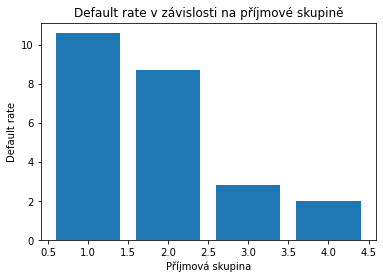

In [554]:
import matplotlib.pyplot as plt

# Zobrazíme výsledky v grafu
plt.bar(default_rate.index, default_rate)
plt.xlabel('Příjmová skupina')
plt.ylabel('Default rate')
plt.title('Default rate v závislosti na příjmové skupině')
plt.show()

První a druhá příjmové skupiny jsou zřejmě několikanásobně rizikovější z pohledu nedodržení závazku splacení s velmi vysokými hodnoty těchto defaultů (10 a 8 procent resp.). Ekonomicky by se dalo inpretovat například tak, že bychom se možná měli vyhýbat poskytování tohoto produktu lidem z těchto příjmových tříd a pro ně vymyslet alternativní produkt, který bude lépe odpovídat jejích ekonomické situaci. 

## Úkol 4

In [555]:
# Počet záznamů
num_observations = len(df)
print("Počet záznamů:", num_observations)

Počet záznamů: 10000


In [556]:
# Počet defaultů
num_defaults = df['default_flg'].sum()
print("Počet defaultů:", num_defaults)

Počet defaultů: 530


In [557]:
# Default rate
default_rate = (num_defaults / num_observations) * 100

# Průměrné LGD
# Přijdeme pouze o 20 procent pokud je nemovistost vlastněná (skopina 3 v proměnné Housing) a naopak 70 procnet u ostatních
average_lgd = (0.2 * df[df['housing'] == 3]['default_flg'].mean() +
               0.7 * df[df['housing'] != 3]['default_flg'].mean()) * 100

print("Default rate:", default_rate)
print("Průměrné LGD:", round(average_lgd, 2))

Default rate: 5.3
Průměrné LGD: 4.88


In [558]:
print("LGD pouze vlastníků nemovistosti:", round(0.2 * df[df['housing'] == 3]['default_flg'].mean() * 100, 2))

LGD pouze vlastníků nemovistosti: 0.35


In [559]:
print("LGD pouze nevlastníků nemovistosti:", round(0.7 * df[df['housing'] != 3]['default_flg'].mean() * 100, 2))

LGD pouze nevlastníků nemovistosti: 4.53


Zde tedy vidíme také moc důležitou informaci, že přicházíme velmi často o peníze v případě nevlastníků nemovitostí. Mohli bychom se tedy opět zaměřit na tuto skupinu a upravit patříčným způsobem podmínky půjček.

In [560]:
# Průměrné IQ
average_iq = df['iq'].mean()

# Průmrný věk
average_age = df['age'].mean()

print("Average IQ:", average_iq)
print("Average Age:", average_age)

Average IQ: 131.9574764026569
Average Age: 42.3077


In [561]:
# Nejčastěji se vyskytující charakteristika v proměnné Housing
most_frequent_housing = df['housing'].mode().values[0]

# Nejčastěji se vyskytující charakteristika v proměnné Educ
most_frequent_educ = df['educ'].mode().values[0]

# Nejčastěji se vyskytující charakteristika v proměnné Inc_Gr
most_frequent_inc_gr = df['inc_gr'].mode().values[0]

print("Nejvíce zastoupený typ ubytování žadatelů:", most_frequent_housing)
print("Nejvíce zastoupený typ vzdělání žadatelů:", most_frequent_educ)
print("Nejvíce zastoupená kategorie objem příjmů žadatelů:", most_frequent_inc_gr)

Nejvíce zastoupený typ ubytování žadatelů: 1
Nejvíce zastoupený typ vzdělání žadatelů: 3
Nejvíce zastoupená kategorie objem příjmů žadatelů: 3


## Úkol 5

### Otázka 1

In [562]:
# Toto je komplexnější úkol, který vyřeším postupně.
# Nejdříve založím sloupec teoretického výnosu z úrokové sazby pro každý řádek, abych s tím mohl dále pohodlně počítat.
df['income_from_rate'] = df['rate'] * 30000

In [563]:
# Výpočet ztrát z defaultů
df['default_loss'] = df['default_flg'] * ( (df['housing'].map({1: 0.7, 2: 0.7, 3: 0.2, 4: 0.7}) * 30000) + (df['housing'].map({1: 0.7, 2: 0.7, 3: 0.2, 4: 0.7}) * df['income_from_rate']) )

In [564]:
# Výpočet výnosu podle ceny distribučních zdrojů
df['channel_cost'] = df['cost_type'].map({'www': 200, 'Facebook': 300, 'Broker': 1000})
df['profit'] = (df['default_flg'].replace({0: 1, 1: 0}) * df['income_from_rate']) - df['default_loss'] - df['channel_cost']

# Za celé portflio
total_profit = df['profit'].sum()

# Za jedntlivé distribuční zdroje
total_profit_by_channel = df.groupby('cost_type')['profit'].sum()

# Za jedntlivé věky
bins_age = pd.interval_range(start=18, end=df['age'].max(), freq=5)
total_profit_by_age = df.groupby(pd.cut(df['age'], bins_age))['profit'].sum()

# Za jedntlivé pohlaví
total_profit_by_gender = df.groupby('gender')['profit'].sum()

# Za jedntlivé jedntlivé rodinné stavy
total_profit_by_marstat = df.groupby('marstat')['profit'].sum()

# Za jedntlivé způsobu bydlení
total_profit_by_housing = df.groupby('housing')['profit'].sum()

# Za jednotlivé typy vzdělání
total_profit_by_educ = df.groupby('educ')['profit'].sum()

# Za jedntlivé příjmové skupiny
total_profit_by_inc_gr = df.groupby('inc_gr')['profit'].sum()

# Za jedntlivé počty dětí
total_profit_by_children = df.groupby('children')['profit'].sum()

# Za jedntlivé intervaly IQ
bins_iq = pd.interval_range(start=40, end=df['iq'].max(), freq=20)
total_profit_by_iq = df.groupby(pd.cut(df['iq'], bins_iq))['profit'].sum()


print("Zisk za celé portflio:")
print(total_profit)
print()
print()
print()
print("Zisk za jedntlivé distribuční zdroje:")
print(total_profit_by_channel)
print()
print()
print()
print("Zisk za jedntlivé věky:")
print(total_profit_by_age)
print()
print()
print()
print('''Zisk za jednotlivé pohlaví:
0 - muž
1 - žena
''')
print(total_profit_by_gender)
print()
print()
print()
print('''Zisk za jedntlivé rodinné stavy:
1 – rozvedený
2 – ženatý
3 – svobodní
4 – okno/muž vdova
''')
print(total_profit_by_marstat)
print()
print()
print()
print('''Zisk za jedntlivé způsoby bydlení:
1 – bydlí s rodiči
2 – registrováno na městském úřadě
3 – ve vlastním domě/bytě
4 – v pronajatém domě/bytě
''')
print(total_profit_by_housing)
print()
print()
print()
print('''Zisk za jednotlivé typy vzdělání:
1 – základní
2 – střední škola
3 – univerzita
4 – PhD.
''')
print(total_profit_by_educ)
print()
print()
print()
print('''Zisk jedntlivé příjmové skupiny:
1 – pobírá sociální zabezpečení
2 – pobírá mzdu nižší než 15 000 Kč
3 – pobírá mzdu od 15 000 Kč do 30 000 Kč
4 – pobírá mzdu nad 30 000 Kč
''')
print(total_profit_by_inc_gr)
print()
print()
print()
print("Zisk za počty dětí:")
print(total_profit_by_children)
print()
print()
print()
print("Zisk za jedntlivé intervaly IQ:")
print(total_profit_by_iq)

Zisk za celé portflio:
-3313164.7970349994



Zisk za jedntlivé distribuční zdroje:
cost_type
Broker     -6.511500e+05
Facebook   -1.129078e+05
www        -2.549107e+06
Name: profit, dtype: float64



Zisk za jedntlivé věky:
age
(18, 23]   -1.318532e+06
(23, 28]   -8.305696e+05
(28, 33]    1.280672e+05
(33, 38]   -6.011144e+05
(38, 43]   -4.441206e+04
(43, 48]    3.330000e+04
(48, 53]   -3.095500e+05
(53, 58]   -2.650000e+03
(58, 63]   -2.017000e+05
Name: profit, dtype: float64



Zisk za jednotlivé pohlaví:
0 - muž
1 - žena

gender
0   -5.445415e+06
1    2.132250e+06
Name: profit, dtype: float64



Zisk za jedntlivé rodinné stavy:
1 – rozvedený
2 – ženatý
3 – svobodní
4 – okno/muž vdova

marstat
1   -1.813147e+06
2    5.103126e+05
3    6.732506e+04
4   -2.077655e+06
Name: profit, dtype: float64



Zisk za jedntlivé způsoby bydlení:
1 – bydlí s rodiči
2 – registrováno na městském úřadě
3 – ve vlastním domě/bytě
4 – v pronajatém domě/bytě

housing
1   -2.671203e+06
2   -2.880993e+06
3  

#### Celkové charakteristiky
Přišlo mi zajímavé prozkoumat i jednotlivé položky zvlášť:

In [565]:
print("Celkové výnosy:", (df['default_flg'].replace({0: 1, 1: 0}) * df['income_from_rate']).sum())

Celkové výnosy: 14382421.78839


In [566]:
print("Celkové ztráty z defaultů:", df['default_loss'].sum())

Celkové ztráty z defaultů: 11098786.585425


In [567]:
print("Celkové ztráty z plateb distributorům:", df['channel_cost'].sum())

Celkové ztráty z plateb distributorům: 6596800


#### Detailnější pohled na distribuční kanály


In [568]:
# Výnosy podle typu distribuce
print((df['default_flg'].replace({0: 1, 1: 0}) * df['income_from_rate']).groupby(df['cost_type']).sum())

cost_type
Broker      8.248500e+06
Facebook    1.071074e+06
www         5.062847e+06
dtype: float64


In [569]:
# Ztráty na ceně distribuce
print(df.groupby('cost_type')['channel_cost'].sum())

cost_type
Broker      5652000
Facebook     225600
www          719200
Name: channel_cost, dtype: int64


In [570]:
# Ztráty na defaultech
print(df.groupby('cost_type')['default_loss'].sum())

cost_type
Broker      3.247650e+06
Facebook    9.583822e+05
www         6.892754e+06
Name: default_loss, dtype: float64


### Otázky 2 a 3

Z pohledu rozdělení dle distribučních kanálů zde jasně vidíme, že momentálně se nejlépe daří Facebooku, jelikož je ve ztrátě "pouze" sto tisíc (v porovnání například se ztrátou dva a půl miliony u klinetů z webu). Utracíme zde nejméně jak za samotné použití (distribuci), tak zde máme i několikanásobně nižší ztráty na defaultech.naopak nejhorším kanálem je pro nás momentálně web, zde jsme přišli, jak již jsme zmínil, o 2,5 milionu korun. Největším důvodem zde budou šílené ztráty na defaultech (skoro 7 milionu korun).

## Úkol 6

Nejlepším klinetem je pro nás postarší, ženatá, vzdělaná žena, která vlastní nemovitost, která pobírá mzdu nad 30 000 Kč.

Naopak nejhorším klientem je pro nás velmi mladý, nevzdělaný muž v prvních rocích své ekonomické aktivity, který bydlí u rodičů a pobírá sociální zabezpečení nebo pobírá mzdu nižší než 15 000 Kč.

## Doporučení managementu

Z provedené analýzy vyplývá, že momentální stav produktu se zcela nedá považovat za přípustný a výhledy do budoucna nejsou vůbec lepší. Přicházíme o spoustu peněz převážně na defaultech u skupin, které nemají vlastní nemovitost. Je tedy potřeba přehodnotit podmínky dosažení této půjčky pro skupiny obyvatelstva, které nemají dostatečný příjem, či způsoby krytí. 

Také je potřeba lépe pracovat a komunikovat s klienty, které mají nízké nejvyšší dosažené vzdělání, jelikož zde dochází k velkjému množství defaultů. Zřejmě nemají dostatečnou finanční gramotnost na to, aby správně zhodnotili všechny své ekonomické rozhodnutí. 

Dále je potřeba přehodnotit práci s distributory, kdy v případě brokerů jsme přišli o neuvěřitelných 5,5 milionů korun, ale rozhodně se nám to v případě tohoto kanálu dostatečně nevrátilo na příjmech. Sice příjmy v tomto segmentu jsou nejvyšší, ale zdaleka ne v takovém poměru jako ztráty na využití tohoto kanálu.